/Volumes/STARLAI/Developments/PyCharmProject/Tuft Dental Segmentation/segmentation/base/model.py:17: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if h % output_stride != 0 or w % output_stride != 0:


Model has been converted to ONNX format and saved at upp_resnet_model.onnx


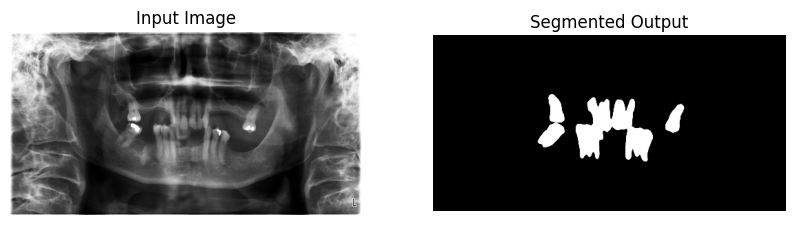

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.onnx
from torch import nn
import torchvision
import albumentations as A

import cv2
from albumentations.pytorch import ToTensorV2

from training import DentalModel

device = "cuda" if torch.cuda.is_available() else "cpu"

simple_transform = A.Compose([
    A.Resize(height=256, width=512),  # Resize to 256x512
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),  # Normalize image to 0-1 range
    ToTensorV2()
])

image_path = 'data/Radiographs/100.JPG'

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
augmented = simple_transform(image=image)
augmented = augmented['image'].unsqueeze(0)
target = augmented.to(device)

arch = "unet"
encoder_name = "resnet34"
path = "tensorboards/unet-resnet34/version_0/checkpoints/best_checkpoint.ckpt"
model = DentalModel.load_from_checkpoint(path, arch=arch, encoder_name=encoder_name, in_channels=3, out_classes=1)

model.to(device)

class ModelWithSigmoid(nn.Module):
    def __init__(self, base_model):
        super(ModelWithSigmoid, self).__init__()
        self.base_model = base_model
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.base_model(x)
        x = self.sigmoid(x)
        return x

model = ModelWithSigmoid(model)


onnx_model_path = "unet_resnet_model.onnx"
torch.onnx.export(
    model, 
    target, 
    onnx_model_path, 
    input_names=['input'], 
    output_names=['output'], 
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},
    opset_version=11
)
print(f"Model has been converted to ONNX format and saved at {onnx_model_path}")

model.eval()
with torch.inference_mode():
    output = model(target)
    output = output.squeeze().cpu().numpy()

# Visualize the segmented output
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Input Image')
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Segmented Output')
plt.imshow(output, cmap='gray')
plt.axis('off')

plt.show()